![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

# 3. Training and Reusing Named Entity Recognition Models

## Related blogposts and videos:

https://towardsdatascience.com/named-entity-recognition-ner-with-bert-in-spark-nlp-874df20d1d77

NerDL worksghop (90 min): https://www.youtube.com/watch?v=YM-e4eOiQ34

https://medium.com/spark-nlp/named-entity-recognition-for-healthcare-with-sparknlp-nerdl-and-nercrf-a7751b6ad571

https://medium.com/atlas-research/ner-for-clinical-text-7c73caddd180

In [0]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *

print("Spark NLP version", sparknlp.version())

print("Apache Spark version:", spark.version)

spark

Spark NLP version 3.0.1
Apache Spark version: 3.0.1
Out[2]:

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.0.1 
 Master 
 spark://10.164.244.12:7077 
 AppName 
 Databricks Shell

## CoNLL Data Prep

In [0]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/src/test/resources/conll2003/eng.train
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/src/test/resources/conll2003/eng.testa

In [0]:
with open("eng.train") as f:
    train_txt =f.read()

print (train_txt[:500])

-DOCSTART- -X- -X- O

EU NNP B-NP B-ORG
rejects VBZ B-VP O
German JJ B-NP B-MISC
call NN I-NP O
to TO B-VP O
boycott VB I-VP O
British JJ B-NP B-MISC
lamb NN I-NP O
. . O O

Peter NNP B-NP B-PER
Blackburn NNP I-NP I-PER

BRUSSELS NNP B-NP B-LOC
1996-08-22 CD I-NP O

The DT B-NP O
European NNP I-NP B-ORG
Commission NNP I-NP I-ORG
said VBD B-VP O
on IN B-PP O
Thursday NNP B-NP O
it PRP B-NP O
disagreed VBD B-VP O
with IN B-PP O
German JJ B-NP B-MISC
advice NN I-NP O
to TO B-PP O
consumers NNS B-NP

In [0]:
from sparknlp.training import CoNLL

training_data = CoNLL().readDataset(spark, 'file:/databricks/driver/eng.train')

training_data.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
 text| document| sentence| token| pos| label|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
EU rejects German...|[{document, 0, 47...|[{document, 0, 47...|[{token, 0, 1, EU...|[{pos, 0, 1, NNP,...|[{named_entity, 0...|
 Peter Blackburn|[{document, 0, 14...|[{document, 0, 14...|[{token, 0, 4, Pe...|[{pos, 0, 4, NNP,...|[{named_entity, 0...|
 BRUSSELS 1996-08-22|[{document, 0, 18...|[{document, 0, 18...|[{token, 0, 7, BR...|[{pos, 0, 7, NNP,...|[{named_entity, 0...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows

In [0]:
training_data.printSchema()

root
-- text: string (nullable = true)
-- document: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)
-- sentence: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)
-- token: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)
-- pos: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)
-- label: array (nullable = false)
 |-- element: struct (containsNull = true)
 | |-- annotatorType: string (nullable = true)
 | |-- begin: integer (nullable = false)
 | |-- end: integer (nullable = false)
 | |-- result: string (nullable = true)
 | |-- metadata: map (nullable = true)
 | | |-- key: string
 | | |-- value: string (valueContainsNull = true)
 | |-- embeddings: array (nullable = true)
 | | |-- element: float (containsNull = false)

In [0]:
training_data.count()

Out[6]: 14041

In [0]:
training_data.cache()

Out[7]: DataFrame[text: string, document: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, sentence: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, token: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, pos: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, label: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>]

In [0]:
%time training_data.count()

CPU times: user 6.21 ms, sys: 4.89 ms, total: 11.1 ms
Wall time: 3.41 s
Out[8]: 14041

In [0]:
%time training_data.count()

CPU times: user 268 µs, sys: 73 µs, total: 341 µs
Wall time: 758 ms
Out[9]: 14041

In [0]:
import pyspark.sql.functions as F

training_data.select(F.explode(F.arrays_zip('token.result', 'pos.result',  'label.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("pos"),
        F.expr("cols['2']").alias("ner_label")).show(truncate=50)

+----------+---+---------+
 token|pos|ner_label|
+----------+---+---------+
 EU|NNP| B-ORG|
 rejects|VBZ| O|
 German| JJ| B-MISC|
 call| NN| O|
 to| TO| O|
 boycott| VB| O|
 British| JJ| B-MISC|
 lamb| NN| O|
 .| .| O|
 Peter|NNP| B-PER|
 Blackburn|NNP| I-PER|
 BRUSSELS|NNP| B-LOC|
1996-08-22| CD| O|
 The| DT| O|
 European|NNP| B-ORG|
Commission|NNP| I-ORG|
 said|VBD| O|
 on| IN| O|
 Thursday|NNP| O|
 it|PRP| O|
+----------+---+---------+
only showing top 20 rows

In [0]:
training_data.select(F.explode(F.arrays_zip('token.result','label.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("ground_truth")).groupBy('ground_truth').count().orderBy('count', ascending=False).show(100,truncate=False)

+------------+------+
ground_truth|count |
+------------+------+
O |169578|
B-LOC |7140 |
B-PER |6600 |
B-ORG |6321 |
I-PER |4528 |
I-ORG |3704 |
B-MISC |3438 |
I-LOC |1157 |
I-MISC |1155 |
+------------+------+

In [0]:
# You can use any word embeddings you want (Glove, Elmo, Bert, custom etc.)

glove_embeddings = WordEmbeddingsModel.pretrained('glove_100d')\
          .setInputCols(["document", "token"])\
          .setOutputCol("embeddings")
    

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][ | ][ / ][ — ][ \ ][OK!]

In [0]:
!mkdir ner_logs

In [0]:
nerTagger = NerDLApproach()\
  .setInputCols(["sentence", "token", "embeddings"])\
  .setLabelColumn("label")\
  .setOutputCol("ner")\
  .setMaxEpochs(1)\
  .setLr(0.003)\
  .setBatchSize(32)\
  .setRandomSeed(0)\
  .setVerbose(1)\
  .setValidationSplit(0.2)\
  .setEvaluationLogExtended(True) \
  .setEnableOutputLogs(True)\
  .setIncludeConfidence(True)\
  .setOutputLogsPath('ner_logs') # if not set, logs will be written to ~/annotator_logs
 #.setGraphFolder('graphs') >> put your graph file (pb) under this folder if you are using a custom graph generated thru 4.1 NerDL-Graph.ipynb notebook
 # .setEnableMemoryOptimizer() >> if you have a limited memory and a large conll file, you can set this True to train batch by batch 
    
ner_pipeline = Pipeline(stages=[
          glove_embeddings,
          nerTagger
 ])


### Fitting

In [0]:
ner_model = ner_pipeline.fit(training_data)

# 1 epoch takes around 3 min with batch size=32
# if you get an error for incompatible TF graph, use 4.1 NerDL-Graph.ipynb notebook to create a graph (or see the bottom cell of this notebook)

In [0]:
%sh cd /databricks/driver/ner_logs && pwd && ls -l

/databricks/driver/ner_logs
total 4
-rw-r--r-- 1 root root 1005 Apr 21 18:55 NerDLApproach_b61b15958428.log

In [0]:
%sh head -n 45 ner_logs/NerDLApproach_b61b15958428.log

Name of the selected graph: ner-dl/blstm_10_100_128_120.pb
Training started - total epochs: 1 - lr: 0.003 - batch size: 32 - labels: 9 - chars: 84 - training examples: 11307


Epoch 1/1 started, lr: 0.003, dataset size: 11307


Epoch 1/1 - 77.30s - loss: 1360.1398 - batches: 355
Quality on validation dataset (20.0%), validation examples = 2261
time to finish evaluation: 6.25s
label tp fp fn prec rec f1
B-LOC 1285 146 124 0.8979734 0.91199434 0.9049296
I-ORG 519 59 188 0.8979239 0.7340877 0.8077821
I-MISC 115 26 99 0.81560284 0.5373832 0.6478873
I-LOC 166 37 62 0.817734 0.7280702 0.7703016
I-PER 881 33 28 0.96389496 0.9691969 0.96653867
B-MISC 591 117 84 0.83474576 0.8755556 0.8546638
B-ORG 974 125 247 0.8862602 0.7977068 0.8396551
B-PER 1247 119 56 0.91288435 0.95702225 0.9344323
tp: 5778 fp: 662 fn: 888 labels: 8
Macro-average prec: 0.8783774, rec: 0.8138771, f1: 0.84489805
Micro-average prec: 0.897205, rec: 0.86678666, f1: 0.8817336

In [0]:
from sparknlp.training import CoNLL

test_data = CoNLL().readDataset(spark, 'file:/databricks/driver/eng.testa')

test_data = glove_embeddings.transform(test_data)

test_data.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
 text| document| sentence| token| pos| label| embeddings|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
CRICKET - LEICEST...|[{document, 0, 64...|[{document, 0, 64...|[{token, 0, 6, CR...|[{pos, 0, 6, NNP,...|[{named_entity, 0...|[{word_embeddings...|
 LONDON 1996-08-30|[{document, 0, 16...|[{document, 0, 16...|[{token, 0, 5, LO...|[{pos, 0, 5, NNP,...|[{named_entity, 0...|[{word_embeddings...|
West Indian all-r...|[{document, 0, 18...|[{document, 0, 18...|[{token, 0, 3, We...|[{pos, 0, 3, NNP,...|[{named_entity, 0...|[{word_embeddings...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows

In [0]:
predictions = ner_model.transform(test_data)
predictions.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
 text| document| sentence| token| pos| label| embeddings| ner|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
CRICKET - LEICEST...|[{document, 0, 64...|[{document, 0, 64...|[{token, 0, 6, CR...|[{pos, 0, 6, NNP,...|[{named_entity, 0...|[{word_embeddings...|[{named_entity, 0...|
 LONDON 1996-08-30|[{document, 0, 16...|[{document, 0, 16...|[{token, 0, 5, LO...|[{pos, 0, 5, NNP,...|[{named_entity, 0...|[{word_embeddings...|[{named_entity, 0...|
West Indian all-r...|[{document, 0, 18...|[{document, 0, 18...|[{token, 0, 3, We...|[{pos, 0, 3, NNP,...|[{named_entity, 0...|[{word_embeddings...|[{named_entity, 0...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows

In [0]:
predictions.select('token.result','label.result','ner.result').show(3, truncate=50)

+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
 result| result| result|
+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
[CRICKET, -, LEICESTERSHIRE, TAKE, OVER, AT, TO...| [O, O, B-ORG, O, O, O, O, O, O, O, O]| [O, O, B-ORG, O, O, O, O, O, O, O, O]|
 [LONDON, 1996-08-30]| [B-LOC, O]| [B-LOC, O]|
[West, Indian, all-rounder, Phil, Simmons, took...|[B-MISC, I-MISC, O, B-PER, I-PER, O, O, O, O, O...|[B-MISC, I-MISC, O, B-PER, I-PER, O, O, O, O, O...|
+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
only showing top 3 rows

### Test set evaluation

In [0]:
import pyspark.sql.functions as F

predictions.select(F.explode(F.arrays_zip('token.result','label.result','ner.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("ground_truth"),
        F.expr("cols['2']").alias("prediction")).show(truncate=False)

+--------------+------------+----------+
token |ground_truth|prediction|
+--------------+------------+----------+
CRICKET |O |O |
- |O |O |
LEICESTERSHIRE|B-ORG |B-ORG |
TAKE |O |O |
OVER |O |O |
AT |O |O |
TOP |O |O |
AFTER |O |O |
INNINGS |O |O |
VICTORY |O |O |
. |O |O |
LONDON |B-LOC |B-LOC |
1996-08-30 |O |O |
West |B-MISC |B-MISC |
Indian |I-MISC |I-MISC |
all-rounder |O |O |
Phil |B-PER |B-PER |
Simmons |I-PER |I-PER |
took |O |O |
four |O |O |
+--------------+------------+----------+
only showing top 20 rows

Licensed user will have an access to internal NERDLMetrics module to do this more efficient and easily without going out of Spark. But open source users need to use sklearen.mnetrics or any other equivalent module to do the same.

In [0]:
from sklearn.metrics import classification_report

preds_df = predictions.select(F.explode(F.arrays_zip('token.result','label.result','ner.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("ground_truth"),
        F.expr("cols['2']").alias("prediction")).toPandas()

print (classification_report(preds_df['ground_truth'], preds_df['prediction']))


precision recall f1-score support

 B-LOC 0.90 0.93 0.91 1837
 B-MISC 0.83 0.84 0.83 922
 B-ORG 0.89 0.77 0.82 1341
 B-PER 0.93 0.96 0.94 1842
 I-LOC 0.80 0.78 0.79 257
 I-MISC 0.73 0.52 0.61 346
 I-ORG 0.88 0.64 0.74 751
 I-PER 0.97 0.96 0.97 1307
 O 0.99 1.00 0.99 42759

 accuracy 0.97 51362
 macro avg 0.88 0.82 0.85 51362
weighted avg 0.97 0.97 0.97 51362

### Entity level evaluation (strict eval)

In [0]:
!wget  -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/utils/conll_eval.py
  
import sys

# Add the path to system, local or mounted S3 bucket, e.g. /dbfs/mnt/<path_to_bucket>
sys.path.append('/databricks/driver/')
#sys.path.append('/databricks/driver/databricks_import_python_module/')
sys.path.append('/databricks/driver/conll_eval.py')

In [0]:
import conll_eval

metrics = conll_eval.evaluate(preds_df['ground_truth'].values, preds_df['prediction'].values)

processed 51362 tokens with 5942 phrases; found: 6026 phrases; correct: 5153.
accuracy: 85.96%; (non-O)
accuracy: 97.40%; precision: 85.51%; recall: 86.72%; FB1: 86.11
 LOC: precision: 88.43%; recall: 92.81%; FB1: 90.57 1928
 MISC: precision: 75.49%; recall: 79.18%; FB1: 77.29 967
 ORG: precision: 79.25%; recall: 72.04%; FB1: 75.47 1219
 PER: precision: 91.63%; recall: 95.11%; FB1: 93.34 1912

In [0]:
# micro, macro, avg
metrics[0]

Out[25]: (85.51277796216395, 86.72164254459777, 86.1129679144385)

In [0]:
import pandas as pd
pd.DataFrame(metrics[1], columns=['entity','precision','recall','f1','support'])

Out[26]:

,entity,precision,recall,f1,support
0,LOC,88.433610,92.814371,90.571049,1928
1,MISC,75.491210,79.175705,77.289571,967
2,ORG,79.245283,72.035794,75.468750,1219
3,PER,91.631799,95.114007,93.340437,1912


### Splitting dataset into train and test

In [0]:
from sparknlp.training import CoNLL

conll_data = CoNLL().readDataset(spark, 'file:/databricks/driver/eng.train')

(training_data, test_data) = conll_data.randomSplit([0.7, 0.3], seed = 100)

print("Training Dataset Count: " + str(training_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

Training Dataset Count: 9745
Test Dataset Count: 4296

In [0]:
glove_embeddings.transform(test_data).write.parquet('nerdl_test.parquet')

In [0]:
nerTagger = NerDLApproach()\
  .setInputCols(["sentence", "token", "embeddings"])\
  .setLabelColumn("label")\
  .setOutputCol("ner")\
  .setMaxEpochs(5)\
  .setLr(0.003)\
  .setBatchSize(32)\
  .setRandomSeed(0)\
  .setVerbose(1)\
  .setValidationSplit(0.2)\
  .setEvaluationLogExtended(True) \
  .setEnableOutputLogs(True)\
  .setIncludeConfidence(True)\
  .setTestDataset('/nerdl_test.parquet')\
  .setOutputLogsPath('ner_logs') # if not set, logs will be written to ~/annotator_logs

ner_pipeline = Pipeline(stages=[
          glove_embeddings,
          nerTagger
 ])

ner_model = ner_pipeline.fit(training_data)

In [0]:
%sh cd ner_logs && ls -lt && pwd

total 12
-rw-r--r-- 1 root root 7776 Apr 21 19:09 NerDLApproach_e1bf8a5c27ab.log
-rw-r--r-- 1 root root 1005 Apr 21 18:55 NerDLApproach_b61b15958428.log
/databricks/driver/ner_logs

In [0]:
%sh cat ner_logs/NerDLApproach_e1bf8a5c27ab.log

Name of the selected graph: ner-dl/blstm_10_100_128_120.pb
Training started - total epochs: 5 - lr: 0.003 - batch size: 32 - labels: 9 - chars: 84 - training examples: 7817


Epoch 1/5 started, lr: 0.003, dataset size: 7817


Epoch 1/5 - 53.52s - loss: 1241.9316 - batches: 247
Quality on validation dataset (20.0%), validation examples = 1563
time to finish evaluation: 4.26s
label tp fp fn prec rec f1
B-LOC 824 165 61 0.8331648 0.9310734 0.87940234
I-ORG 412 91 134 0.8190855 0.75457877 0.78551006
I-MISC 92 42 77 0.6865672 0.5443787 0.60726076
I-LOC 105 36 35 0.7446808 0.75 0.7473309
I-PER 549 34 10 0.94168097 0.9821109 0.9614711
B-MISC 318 34 120 0.90340906 0.72602737 0.80506325
B-ORG 782 191 139 0.8036999 0.8490771 0.8257656
B-PER 806 74 50 0.9159091 0.94158876 0.9285714
tp: 3888 fp: 667 fn: 626 labels: 8
Macro-average prec: 0.8310247, rec: 0.80985445, f1: 0.82030296
Micro-average prec: 0.8535675, rec: 0.8613203, f1: 0.8574264
Quality on test dataset: 
time to finish evaluation: 8.90s
label tp fp fn prec rec f1
B-LOC 2040 405 122 0.83435583 0.9435708 0.8856088
I-ORG 771 207 246 0.78834355 0.7581121 0.7729323
I-MISC 202 100 141 0.66887414 0.5889213 0.62635654
I-LOC 276 73 61 0.79083097 0.8189911 0.8046648
I-PER 1415 97 26 0.93584657 0.98195696 0.95834744
B-MISC 779 75 293 0.912178 0.7266791 0.80893034
B-ORG 1583 386 318 0.8039614 0.8327196 0.8180878
B-PER 1926 173 136 0.9175798 0.9340446 0.925739
tp: 8992 fp: 1516 fn: 1343 labels: 8
Macro-average prec: 0.8314963, rec: 0.8231245, f1: 0.8272892
Micro-average prec: 0.855729, rec: 0.87005323, f1: 0.8628317


Epoch 2/5 started, lr: 0.0029850747, dataset size: 7817


Epoch 2/5 - 51.51s - loss: 377.2035 - batches: 247
Quality on validation dataset (20.0%), validation examples = 1563
time to finish evaluation: 3.98s
label tp fp fn prec rec f1
B-LOC 765 36 120 0.9550562 0.86440676 0.9074733
I-ORG 464 90 82 0.8375451 0.84981686 0.84363633
I-MISC 95 30 74 0.76 0.56213015 0.6462585
I-LOC 100 7 40 0.93457943 0.71428573 0.8097166
I-PER 550 16 9 0.9717314 0.98389983 0.9777778
B-MISC 379 65 59 0.8536036 0.8652968 0.8594104
B-ORG 833 173 88 0.82803184 0.90445167 0.8645563
B-PER 818 56 38 0.9359268 0.9556075 0.94566476
tp: 4004 fp: 473 fn: 510 labels: 8
Macro-average prec: 0.8845593, rec: 0.8374869, f1: 0.86037976
Micro-average prec: 0.8943489, rec: 0.88701814, f1: 0.89066845
Quality on test dataset: 
time to finish evaluation: 8.77s
label tp fp fn prec rec f1
B-LOC 1926 90 236 0.95535713 0.89084184 0.9219722
I-ORG 841 221 176 0.79190207 0.82694197 0.8090428
I-MISC 232 54 111 0.8111888 0.67638487 0.7376789
I-LOC 251 37 86 0.8715278 0.7448071 0.8032
I-PER 1414 51 27 0.9651877 0.98126304 0.973159
B-MISC 925 133 147 0.8742911 0.86287314 0.86854464
B-ORG 1685 326 216 0.8378916 0.8863756 0.86145186
B-PER 1977 126 85 0.9400856 0.9587779 0.9493397
tp: 9251 fp: 1038 fn: 1084 labels: 8
Macro-average prec: 0.8809289, rec: 0.85353315, f1: 0.86701465
Micro-average prec: 0.89911556, rec: 0.8951137, f1: 0.89711016


Epoch 3/5 started, lr: 0.0029702971, dataset size: 7817


Epoch 3/5 - 52.03s - loss: 275.462 - batches: 247
Quality on validation dataset (20.0%), validation examples = 1563
time to finish evaluation: 3.90s
label tp fp fn prec rec f1
B-LOC 763 20 122 0.9744572 0.8621469 0.9148681
I-ORG 505 209 41 0.7072829 0.9249084 0.8015873
I-MISC 92 14 77 0.8679245 0.5443787 0.6690909
I-LOC 75 2 65 0.97402596 0.53571427 0.69124424
I-PER 538 14 21 0.9746377 0.9624329 0.96849686
B-MISC 351 24 87 0.936 0.80136985 0.8634687
B-ORG 849 214 72 0.798683 0.9218241 0.85584676
B-PER 796 41 60 0.95101553 0.92990655 0.94034255
tp: 3969 fp: 538 fn: 545 labels: 8
Macro-average prec: 0.89800334, rec: 0.81033516, f1: 0.8519198
Micro-average prec: 0.88063014, rec: 0.87926453, f1: 0.8799468
Quality on test dataset: 
time to finish evaluation: 8.62s
label tp fp fn prec rec f1
B-LOC 1890 54 272 0.9722222 0.87419057 0.92060393
I-ORG 941 521 76 0.64363885 0.9252704 0.75917715
I-MISC 215 31 128 0.87398374 0.6268222 0.7300509
I-LOC 183

In [0]:
test_data = glove_embeddings.transform(test_data)

predictions = ner_model.transform(test_data)

from sklearn.metrics import classification_report

preds_df = predictions.select(F.explode(F.arrays_zip('token.result','label.result','ner.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("ground_truth"),
        F.expr("cols['2']").alias("prediction")).toPandas()

print (classification_report(preds_df['ground_truth'], preds_df['prediction'], digits=4))


precision recall f1-score support

 B-LOC 0.9567 0.9514 0.9541 2162
 B-MISC 0.9074 0.9142 0.9108 1072
 B-ORG 0.9338 0.8832 0.9078 1901
 B-PER 0.9302 0.9825 0.9557 2062
 I-LOC 0.8984 0.8398 0.8681 337
 I-MISC 0.7781 0.8280 0.8023 343
 I-ORG 0.8863 0.8584 0.8721 1017
 I-PER 0.9558 0.9903 0.9727 1441
 O 0.9964 0.9958 0.9961 52279

 accuracy 0.9849 62614
 macro avg 0.9159 0.9160 0.9155 62614
weighted avg 0.9850 0.9849 0.9849 62614

### Ner log parser

In [0]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/utils/ner_log_parser.py
  
sys.path.append('/databricks/driver/ner_log_parser.py')

In [0]:
import ner_log_parser

In [0]:
%matplotlib inline

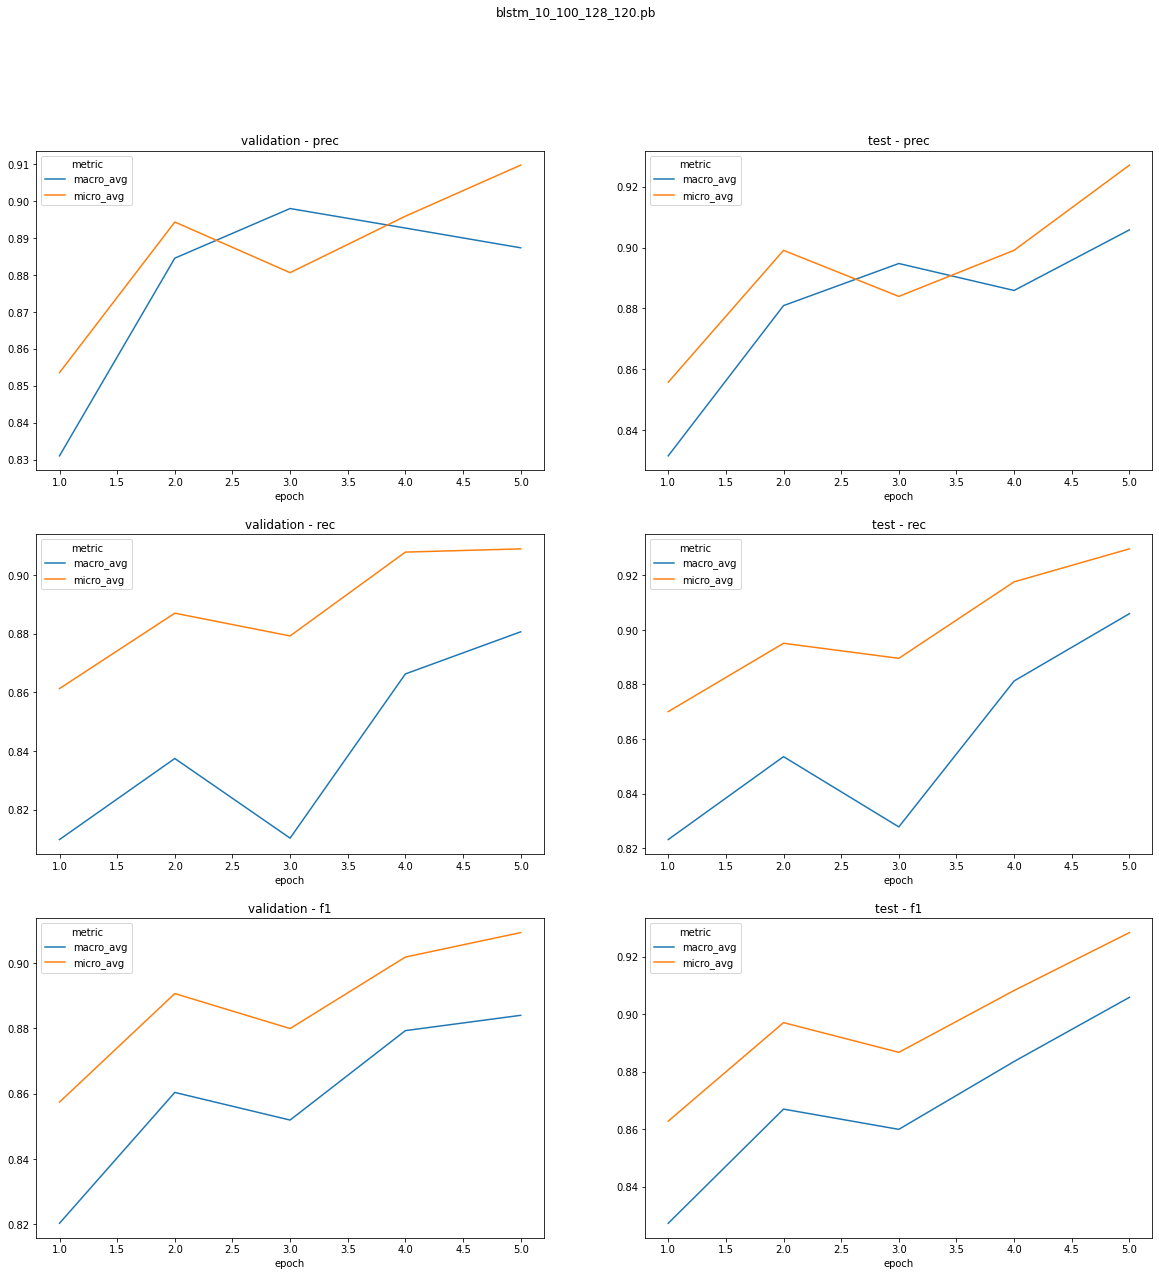

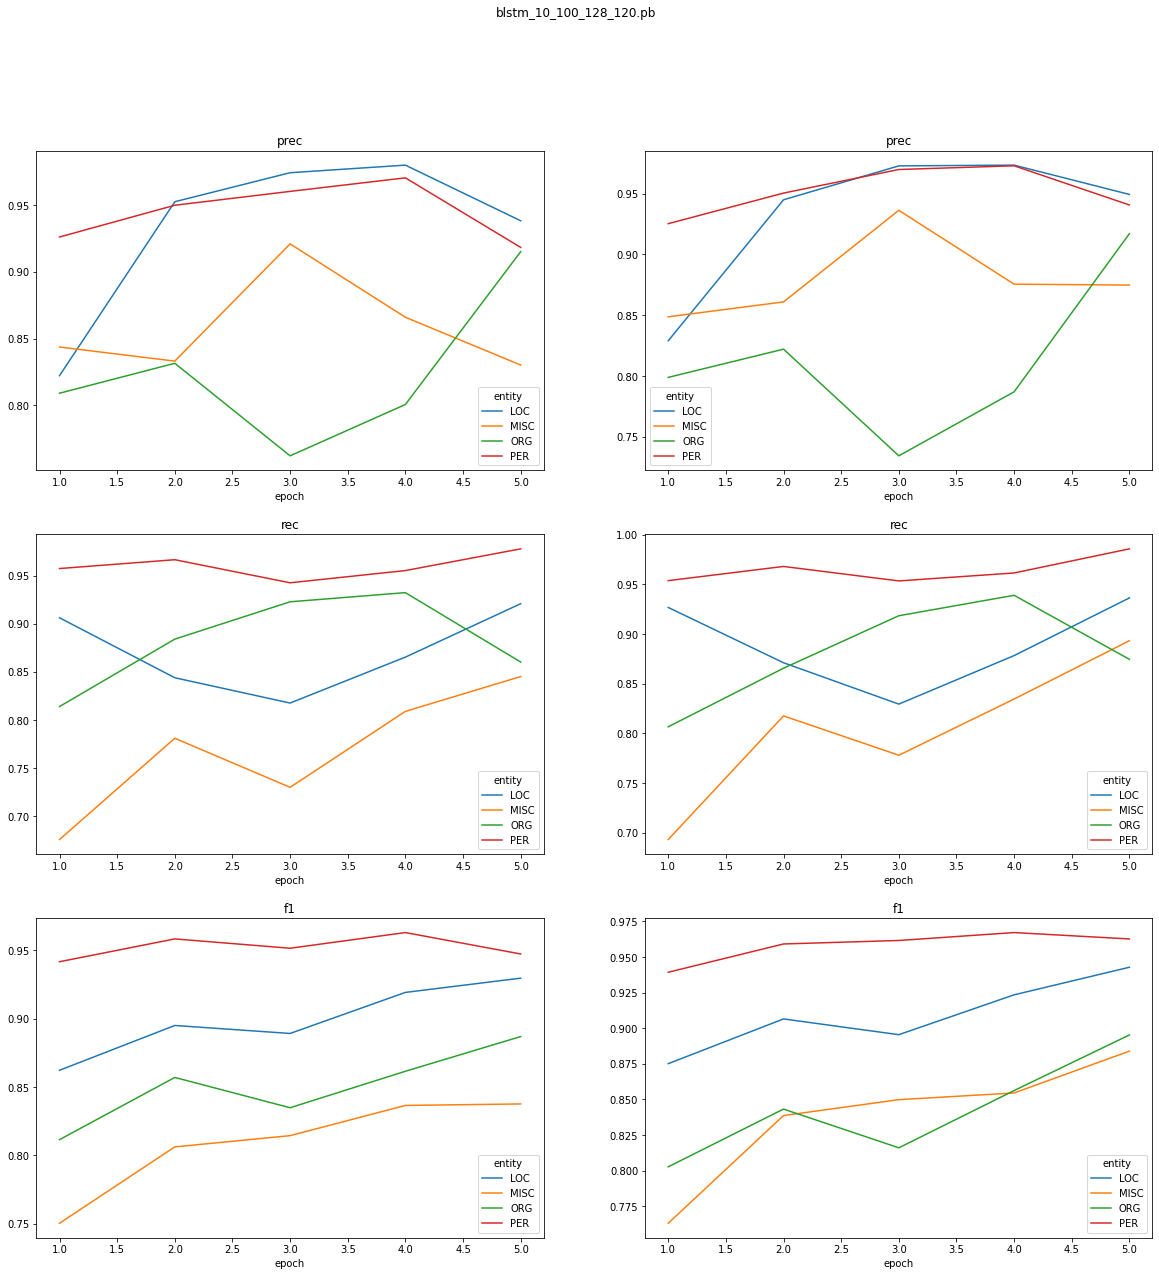

In [0]:
ner_log_parser.get_charts('/databricks/driver/ner_logs/NerDLApproach_e1bf8a5c27ab.log')

### Saving the trained model

In [0]:
ner_model.stages

Out[40]: [WORD_EMBEDDINGS_MODEL_48cffc8b9a76, NerDLModel_15b0c74b8e13]

In [0]:
%sh cd /databricks/driver/ && ls -la

total 4068
drwxr-xr-x 1 root root 4096 Apr 21 19:20 .
drwxr-xr-x 1 root root 4096 Apr 21 18:27 ..
drwxr-xr-x 2 root root 4096 Apr 21 19:20 __pycache__
drwxr-xr-x 2 root root 4096 Jan 1 1970 conf
-rw-r--r-- 1 root root 7431 Apr 21 19:00 conll_eval.py
-rw-r--r-- 1 root root 827443 Apr 21 18:30 eng.testa
-rw-r--r-- 1 root root 3283420 Apr 21 18:30 eng.train
drwxr-xr-x 3 root root 4096 Apr 21 18:27 eventlogs
drwxr-xr-x 2 root root 4096 Apr 21 19:15 ganglia
drwxr-xr-x 2 root root 4096 Apr 21 19:01 logs
-rw-r--r-- 1 root root 3311 Apr 21 19:20 ner_log_parser.py
drwxr-xr-x 2 root root 4096 Apr 21 19:03 ner_logs

In [0]:
ner_model.stages[1].write().overwrite().save('/databricks/driver/models/NerDLModel_3010')

In [0]:
%fs ls /databricks/driver/models

path,name,size
dbfs:/databricks/driver/models/ClassifierDL_USE_20200211_e5/,ClassifierDL_USE_20200211_e5/,0
dbfs:/databricks/driver/models/ClassifierDL_USE_20203010_e5/,ClassifierDL_USE_20203010_e5/,0
dbfs:/databricks/driver/models/ClassifierDL_wordemb_g100d/,ClassifierDL_wordemb_g100d/,0
dbfs:/databricks/driver/models/NER_glove_20200924_e1_b32/,NER_glove_20200924_e1_b32/,0
dbfs:/databricks/driver/models/NerDLModel_3010/,NerDLModel_3010/,0
dbfs:/databricks/driver/models/assertion_model_0804/,assertion_model_0804/,0
dbfs:/databricks/driver/models/bert_sent/,bert_sent/,0
dbfs:/databricks/driver/models/biobertresolve_snomed_askapatient/,biobertresolve_snomed_askapatient/,0
dbfs:/databricks/driver/models/chunkresolve_snomed_askapatient_hc_100d/,chunkresolve_snomed_askapatient_hc_100d/,0
dbfs:/databricks/driver/models/custom_NER_3epoch/,custom_NER_3epoch/,0


## Prediction Pipeline

In [0]:
document = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentence = SentenceDetector()\
    .setInputCols(['document'])\
    .setOutputCol('sentence')

token = Tokenizer()\
    .setInputCols(['sentence'])\
    .setOutputCol('token')

glove_embeddings = WordEmbeddingsModel.pretrained('glove_100d')\
    .setInputCols(["document", "token"])\
    .setOutputCol("embeddings")
    
loaded_ner_model = NerDLModel.load("/databricks/driver/models/NerDLModel_3010")\
     .setInputCols(["sentence", "token", "embeddings"])\
     .setOutputCol("ner")

converter = NerConverter()\
      .setInputCols(["document", "token", "ner"])\
      .setOutputCol("ner_span")

ner_prediction_pipeline = Pipeline(
    stages = [
        document,
        sentence,
        token,
        glove_embeddings,
        loaded_ner_model,
        converter])

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[ | ][OK!]

In [0]:
empty_data = spark.createDataFrame([['']]).toDF("text")

prediction_model = ner_prediction_pipeline.fit(empty_data)


In [0]:
text = "Peter Parker is a nice guy and lives in New York."

sample_data = spark.createDataFrame([[text]]).toDF("text")

sample_data.show(truncate=False)

+-------------------------------------------------+
text |
+-------------------------------------------------+
Peter Parker is a nice guy and lives in New York.|
+-------------------------------------------------+

In [0]:
preds = prediction_model.transform(sample_data)

preds.select(F.explode(F.arrays_zip("ner_span.result","ner_span.metadata")).alias("entities")) \
.select(F.expr("entities['0']").alias("chunk"),
        F.expr("entities['1'].entity").alias("entity")).show(truncate=False)

+------------+------+
chunk |entity|
+------------+------+
Peter Parker|PER |
New York |LOC |
+------------+------+

In [0]:
from sparknlp.base import LightPipeline

light_model = LightPipeline(prediction_model)

In [0]:
text = "Peter Parker is a nice guy and lives in New York."

result = light_model.annotate(text)

list(zip(result['token'], result['ner']))

Out[65]: [('Peter', 'B-PER'),
 ('Parker', 'I-PER'),
 ('is', 'O'),
 ('a', 'O'),
 ('nice', 'O'),
 ('guy', 'O'),
 ('and', 'O'),
 ('lives', 'O'),
 ('in', 'O'),
 ('New', 'B-LOC'),
 ('York', 'I-LOC'),
 ('.', 'O')]

In [0]:
import pandas as pd

result = light_model.fullAnnotate(text)

ner_df= pd.DataFrame([(int(x.metadata['sentence']), x.result, x.begin, x.end, y.result) for x,y in zip(result[0]["token"], result[0]["ner"])], 
                      columns=['sent_id','token','start','end','ner'])
ner_df

Out[66]:

,sent_id,token,start,end,ner
0,0,Peter,0,4,B-PER
1,0,Parker,6,11,I-PER
2,0,is,13,14,O
3,0,a,16,16,O
4,0,nice,18,21,O
5,0,guy,23,25,O
6,0,and,27,29,O
7,0,lives,31,35,O
8,0,in,37,38,O
9,0,New,40,42,B-LOC


# creating your own CoNLL dataset¶

for a detailed overview of how to create a CoNLL file from any annotation, see here >> https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/1.3.prepare_CoNLL_from_annotations_for_NER.ipynb

In [0]:
import json
import os
from pyspark.ml import Pipeline
from sparknlp.base import *
from sparknlp.annotator import *
import sparknlp

spark = sparknlp.start()

def get_ann_pipeline ():
    
    document_assembler = DocumentAssembler() \
        .setInputCol("text")\
        .setOutputCol('document')

    tokenizer = Tokenizer() \
        .setInputCols(["sentence"]) \
        .setOutputCol("token")

    pos = PerceptronModel.pretrained() \
              .setInputCols(["sentence", "token"]) \
              .setOutputCol("pos")
    
    embeddings = WordEmbeddingsModel.pretrained()\
          .setInputCols(["sentence", "token"])\
          .setOutputCol("embeddings")

    ner_model = NerDLModel.pretrained() \
          .setInputCols(["sentence", "token", "embeddings"]) \
          .setOutputCol("ner")

    ner_converter = NerConverter()\
      .setInputCols(["sentence", "token", "ner"])\
      .setOutputCol("ner_chunk")

    ner_pipeline = Pipeline(
        stages = [
            document_assembler,
            sentence,
            tokenizer,
            pos,
            embeddings,
            ner_model,
            ner_converter
        ]
    )

    empty_data = spark.createDataFrame([[""]]).toDF("text")

    ner_pipelineFit = ner_pipeline.fit(empty_data)

    ner_lp_pipeline = LightPipeline(ner_pipelineFit)

    print ("Spark NLP NER lightpipeline is created")

    return ner_lp_pipeline


conll_pipeline = get_ann_pipeline ()



pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[ | ][OK!]
glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[ | ][OK!]
ner_dl download started this may take some time.
Approximate size to download 13.6 MB
[ | ][OK!]
Spark NLP NER lightpipeline is created

In [0]:
sentences = ["Peter Parker is a nice guy and lives in New York.",
"He is also helping people around the world."]

conll_lines=''

for sentence in sentences:

  parsed = conll_pipeline.annotate (sentence)

  for token, pos, ner in zip(parsed['token'],parsed['pos'],parsed['ner']):

      conll_lines += "{} {} {} {}\n".format(token, pos, pos, ner)

  conll_lines += '\n'


print(conll_lines)

Peter NNP NNP B-PER
Parker NNP NNP I-PER
is VBZ VBZ O
a DT DT O
nice JJ JJ O
guy NN NN O
and CC CC O
lives NNS NNS O
in IN IN O
New NNP NNP B-LOC
York NNP NNP I-LOC
. . . O

He PRP PRP O
is VBZ VBZ O
also RB RB O
helping VBG VBG O
people NNS NNS O
around IN IN O
the DT DT O
world NN NN O
. . . O

# NerDL Graph

Licensed users would use this module to create graphs for each DL model (`ner_dl`, `generic_classifier`, `assertion_dl`, `relation_extraction`) in Spark NLP but in open source, you need to run the other cell.

```
%tensorflow_version 1.x

from sparknlp_jsl.training import tf_graph

tf_graph.build("ner_dl", build_params={"embeddings_dim": 200, "nchars": 80, "ntags": 12}, model_location="./", model_filename="auto")
```

In [0]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/create_graph.py
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/dataset_encoder.py
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/ner_model.py
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/ner_model_saver.py
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/sentence_grouper.py
import sys
sys.path.append('/databricks/driver/')
sys.path.append('/databricks/driver/create_graph.py')
import create_graph
ntags = 19 # number of labels
embeddings_dim = 100
nchars =100
create_graph.create_graph(ntags, embeddings_dim, nchars)

In [0]:
%sh
ls -lt

total 31444
-rw-r--r-- 1 root root 1641858 Nov 9 21:37 blstm_15_105_128_112.pb
-rw-r--r-- 1 root root 953 Nov 9 21:37 sentence_grouper.py
-rw-r--r-- 1 root root 2484 Nov 9 21:37 ner_model_saver.py
-rw-r--r-- 1 root root 21853 Nov 9 21:37 ner_model.py
-rw-r--r-- 1 root root 2543 Nov 9 21:37 dataset_encoder.py
-rw-r--r-- 1 root root 1545 Nov 9 21:37 create_graph.py
drwxr-xr-x 2 root root 4096 Nov 9 21:30 ganglia
-rw-r--r-- 1 root root 1641858 Nov 9 21:19 blstm_19_100_128_100.pb
drwxr-xr-x 2 root root 4096 Nov 9 21:19 __pycache__
drwxr-xr-x 2 root root 4096 Nov 9 21:00 logs
-rw-r--r-- 1 root root 1504408 Nov 9 19:05 news_category_test.csv
drwxr-xr-x 2 root root 4096 Nov 9 19:02 models
drwxr-xr-x 2 root root 4096 Nov 9 18:58 ner_logs
-rw-r--r-- 1 root root 3283420 Nov 9 17:28 eng.train
-rw-r--r-- 1 root root 27 Nov 9 13:43 financial_entities.txt
-rw-r--r-- 1 root root 36 Nov 9 13:43 sport_entities.txt
-rw-r--r-- 1 root root 24032125 Nov 9 13:43 news_category_train.csv
-rw-r--r-- 1 root root 284 Nov 9 13:34 sample-sentences-en.txt
-rw-r--r-- 1 root root 724 Nov 9 09:55 derby.log
drwxr-xr-x 3 root root 4096 Nov 9 09:55 eventlogs
drwxr-xr-x 2 root root 4096 Jan 1 1970 conf

End of Notebook # 4